<Axes: xlabel='target'>

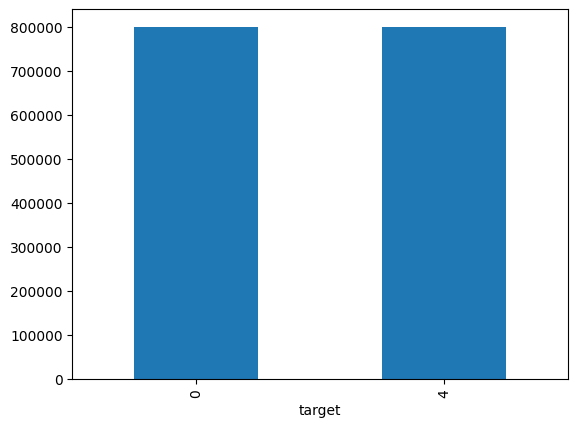

In [2]:
import pandas as pd

df = pd.read_csv(
  filepath_or_buffer='/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',
  encoding="ISO-8859-1",
  usecols=[0, 5],
  names=['target', 'text'],
  engine='python',
  on_bad_lines='skip',  # Replaces 'error_bad_lines=False'
)

df['target'].value_counts().plot(kind='bar')


In [4]:
import pandas as pd

df = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',
               encoding="ISO-8859-1",
                 index_col=False,
                 names = ['label', 'id', 'date', 'query', 'user_id', 'tweet'])

df.set_index('id', inplace=True)
df.head()

,label,date,query,user_id,tweet
id,,,,,
1467810369,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1467810672,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1467810917,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
1467811184,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# adjust labels to [0, 1], this is just the way the model likes it
label_dict = {}
for index, label in enumerate(df.label.unique()):
    label_dict[label] = index
df['label'] = df.label.replace(label_dict)

# shuffle rows and take only 100 000 samples
# or feel free to use the full set
df = df.sample(frac = 1)[0:100000]

# test / validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size = 0.15, # ... using a 15/85 % test/validation split
    random_state = 60
)

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type'])['tweet'].count()

label  data_type
0      train        42497
       val           7536
1      train        42500
       val           7467
Name: tweet, dtype: int64

In [6]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].tweet.values,
    add_special_tokens=True, # ... Berts way of knowing sentence start/end
    return_attention_mask=True, # ... using a fixed input (dim will == 256, will tell us where blank info is)
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

# validation
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].tweet.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
import torch

input_ids_train = encoded_data_train['input_ids']
attention_mask_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

dataset_train = TensorDataset(input_ids_train,
                              attention_mask_train,
                              labels_train)

input_ids_val = encoded_data_val['input_ids']
attention_mask_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_val = TensorDataset(input_ids_val,
                            attention_mask_val,
                            labels_val)


In [9]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions=False, # attending to certain words more than others
    output_hidden_states=False
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size,
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32,
)

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 1

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs,
)

In [17]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    labels_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {labels_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])} / {len(y_true)}\n')

In [18]:
import random

seed_val = 6
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [19]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':       batch[0],
                  'attention_mask':  batch[1],
                  'labels':          batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [20]:
from tqdm.notebook import tqdm

for epoch in tqdm(range(1,epochs+1)):

    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:

        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids' : batch[0],
            'attention_mask' : batch[1],
            'labels' : batch[2]
        }

        outputs = model(**inputs) # feed bert our inputs

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # back propoagation step

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # step optimizer & scheduler
        optimizer.step()
        scheduler.step()

        # update progress bar and end batch loop
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))}) # loss of current item / batch length

    model.save_pretrained(f'Models/BERT_ft_epoch{epoch}/') # ... save model every epoch
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2657 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.39427185315452307
Validation loss: 0.37001895869591594
F1 Score (weighted): 0.8390124953384734


In [27]:
# Save the model's state_dict instead of the entire model in a directory
torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.bin')


In [28]:
model.load_state_dict(
    torch.load('/content/Models/BERT_ft_epoch1.bin',
               map_location=torch.device('cpu'))
)


<ipython-input-28-af506fe3c5a8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('/content/Models/BERT_ft_epoch1.bin',


<All keys matched successfully>

In [29]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

model.load_state_dict(
    torch.load('/content/Models/BERT_ft_epoch1.bin',
               map_location=torch.device('cpu'))
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-29-a7010c89e042>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

<All keys matched successfully>

In [30]:
# Save the entire model
torch.save(model, 'Models/BERT_ft_epoch1.model')


In [31]:
_, predictions, true_vals = evaluate(dataloader_val)

accuracy_per_class(predictions, true_vals)

Class: 0
Accuracy: 14 / 7536

Class: 4
Accuracy: 7458 / 7467



In [35]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Define the model path
model_path = './Models/BERT_ft_epoch1/'

# Load the model
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Create the text classification pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

# Now you can use the classifier for predictions


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [36]:
label_map = {'LABEL_0': 'Negative', 'LABEL_1': 'Positive'}

result = classifier("This is the best BERT guide")

print("Predicted label:", label_map[result[0]['label']])
print("Score:", round(result[0]['score'],3))

Predicted label: Positive
Score: 0.981


In [38]:
result = classifier("I'm disapointed that it has taken so long to discover this fantastic BERT guide")

print("Predicted label:", label_map[result[0]['label']])
print("Score:", round(result[0]['score'],3))

Predicted label: Negative
Score: 0.9
